In [1]:
import numpy as np
from sklearn.linear_model import LassoCV, Lasso, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.stats import norm
import matplotlib.pyplot as plt
import warnings
import pandas as pd
import statsmodels.api as sm
warnings.filterwarnings("ignore")

### Question 6: Double Lasso Model Comparisons

***Double LASSO with Estimation***

In [2]:
def double_lasso_estimation(Y, X, lasso_method):
    D = X[:, 0]
    Z = X[:, 1:]

    # Lasso regression for Y on D and Z
    lasso_Y = lasso_method(X, Y)
    selected_covariates_Y = np.where(lasso_Y.coef_[1:] != 0)[0]
    gamma_hat = lasso_Y.coef_[1:]

    # Lasso regression for D on Z
    lasso_D = lasso_method(Z, D)
    selected_covariates_D = np.where(lasso_D.coef_ != 0)[0]

    # Ensure the indices are correct for Z
    selected_covariates = np.union1d(selected_covariates_Y, selected_covariates_D)
    Z_selected = Z[:, selected_covariates]

    # Calculate residuals
    Y_res = Y - Z_selected.dot(gamma_hat[selected_covariates])
    D_res = D - Z_selected.dot(lasso_D.coef_[selected_covariates])

    # Estimate alpha
    numerator = np.sum(Y_res * D_res)
    denominator = np.sum(D * D_res)
    alpha_tilde = numerator / denominator

    e = D_res
    nu = Y_res
    V = np.mean(e**2 * nu**2) / (np.mean(nu**2))**2
    asymptotic_std_error = np.sqrt(V / len(D_res))

    return alpha_tilde, asymptotic_std_error


***Double LASSO with OLS***

In [3]:
def double_lasso_ols(Y, X, lasso_method):
    D = X[:, 0]
    Z = X[:, 1:]

    # Lasso regression for Y on D and Z
    lasso_Y = lasso_method(X, Y)
    selected_covariates_Y = np.where(lasso_Y.coef_[1:] != 0)[0]

    # Lasso regression for D on Z
    lasso_D = lasso_method(Z, D)
    selected_covariates_D = np.where(lasso_D.coef_ != 0)[0]

    selected_covariates = np.union1d(selected_covariates_Y, selected_covariates_D)
    Z_selected = Z[:, selected_covariates]

    # OLS of Y on D and selected covariates
    X_final = np.column_stack((D, Z_selected))
    ols_model = LinearRegression().fit(X_final, Y)
    alpha_hat = ols_model.coef_[0]

    residuals = Y - ols_model.predict(X_final)
    se = np.sqrt(np.sum(residuals**2) / (X_final.shape[0] - X_final.shape[1]))

    return alpha_hat, se


***Double LASSO with OLS and Cross-fitting***

In [4]:
def cross_fitted_double_lasso_ols(Y, X, lasso_method):
    # Split the data into two halves
    X1, X2, Y1, Y2 = train_test_split(X, Y, test_size=0.5, random_state=42)

    # First half for lasso
    D1 = X1[:, 0]
    Z1 = X1[:, 1:]
    lasso_Y1 = lasso_method(X1, Y1)
    selected_covariates_Y1 = np.where(lasso_Y1.coef_ != 0)[0]
    selected_covariates_Y1 = selected_covariates_Y1[selected_covariates_Y1 != 0] - 1
    lasso_D1 = lasso_method(Z1, D1)
    selected_covariates_D1 = np.where(lasso_D1.coef_ != 0)[0]
    selected_covariates1 = np.union1d(selected_covariates_Y1, selected_covariates_D1)
    Z1_selected = Z1[:, selected_covariates1]

    # Second half for OLS
    D2 = X2[:, 0]
    Z2 = X2[:, 1:]
    Z2_selected = Z2[:, selected_covariates1]
    X2_final = np.column_stack((D2, Z2_selected))
    ols_model2 = LinearRegression().fit(X2_final, Y2)
    alpha_hat2 = ols_model2.coef_[0]

    # Switch roles
    # Second half for lasso
    lasso_Y2 = lasso_method(X2, Y2)
    selected_covariates_Y2 = np.where(lasso_Y2.coef_ != 0)[0]
    selected_covariates_Y2 = selected_covariates_Y2[selected_covariates_Y2 != 0] - 1
    lasso_D2 = lasso_method(Z2, D2)
    selected_covariates_D2 = np.where(lasso_D2.coef_ != 0)[0]
    selected_covariates2 = np.union1d(selected_covariates_Y2, selected_covariates_D2)
    Z2_selected = Z2[:, selected_covariates2]

    # First half for OLS
    Z1_selected = Z1[:, selected_covariates2]
    X1_final = np.column_stack((D1, Z1_selected))
    ols_model1 = LinearRegression().fit(X1_final, Y1)
    alpha_hat1 = ols_model1.coef_[0]

    # Averaging the results
    alpha_hat = (alpha_hat1 + alpha_hat2) / 2

    residuals1 = Y1 - ols_model1.predict(X1_final)
    residuals2 = Y2 - ols_model2.predict(X2_final)
    se1 = np.sqrt(np.sum(residuals1**2) / (X1_final.shape[0] - X1_final.shape[1]))
    se2 = np.sqrt(np.sum(residuals2**2) / (X2_final.shape[0] - X2_final.shape[1]))
    se_hat = (se1 + se2) / 2

    return alpha_hat, se_hat

***Double LASSO with Estimation and Cross-fitting***

In [5]:
def cross_fitted_double_lasso_estimation(Y, X, lasso_method):
    # Split the data into two halves
    X1, X2, Y1, Y2 = train_test_split(X, Y, test_size=0.5, random_state=42)

    # First half for lasso
    D1 = X1[:, 0]
    Z1 = X1[:, 1:]
    lasso_Y1 = lasso_method(X1, Y1)
    selected_covariates_Y1 = np.where(lasso_Y1.coef_ != 0)[0]
    gamma_hat1 = lasso_Y1.coef_[1:]
    lasso_D1 = lasso_method(Z1, D1)
    selected_covariates_D1 = np.where(lasso_D1.coef_ != 0)[0]
    selected_covariates_Y1 = selected_covariates_Y1[selected_covariates_Y1 > 0] - 1
    selected_covariates1 = np.union1d(selected_covariates_Y1, selected_covariates_D1)
    Z1_selected = Z1[:, selected_covariates1]

    # Second half for estimation
    D2 = X2[:, 0]
    Z2 = X2[:, 1:]
    Z2_selected = Z2[:, selected_covariates1]
    Y2_res = Y2 - Z2_selected.dot(gamma_hat1[selected_covariates1])
    D2_res = D2 - Z2_selected.dot(lasso_D1.coef_[selected_covariates1])
    numerator2 = np.sum(Y2_res * D2_res)
    denominator2 = np.sum(D2 * D2_res)
    alpha_tilde2 = numerator2 / denominator2

    # Switch roles
    # Second half for lasso
    lasso_Y2 = lasso_method(X2, Y2)
    selected_covariates_Y2 = np.where(lasso_Y2.coef_ != 0)[0]
    gamma_hat2 = lasso_Y2.coef_[1:]
    lasso_D2 = lasso_method(Z2, D2)
    selected_covariates_D2 = np.where(lasso_D2.coef_ != 0)[0]
    selected_covariates_Y2 = selected_covariates_Y2[selected_covariates_Y2 > 0] - 1
    selected_covariates2 = np.union1d(selected_covariates_Y2, selected_covariates_D2)
    Z2_selected = Z2[:, selected_covariates2]

    # First half for estimation
    Z1_selected = Z1[:, selected_covariates2]
    Y1_res = Y1 - Z1_selected.dot(gamma_hat2[selected_covariates2])
    D1_res = D1 - Z1_selected.dot(lasso_D2.coef_[selected_covariates2])
    numerator1 = np.sum(Y1_res * D1_res)
    denominator1 = np.sum(D1 * D1_res)
    alpha_tilde1 = numerator1 / denominator1

    # Averaging the results
    alpha_tilde = (alpha_tilde1 + alpha_tilde2) / 2

    e1 = D1_res
    nu1 = Y1_res
    e2 = D2_res
    nu2 = Y2_res
    V1 = np.mean(e1**2 * nu1**2) / (np.mean(nu1**2))**2
    V2 = np.mean(e2**2 * nu2**2) / (np.mean(nu2**2))**2
    asymptotic_std_error1 = np.sqrt(V1 / len(D1_res))
    asymptotic_std_error2 = np.sqrt(V2 / len(D2_res))
    asymptotic_std_error = (asymptotic_std_error1 + asymptotic_std_error2) / 2

    return alpha_tilde, asymptotic_std_error

***LASSO with BCCH***

In [6]:
def bcch_lasso(X, y, alpha=0.05, c=1.1):
    n, p = X.shape

    # Standardize variables
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

    # Calculate scale for pilot penalty
    y_squared = (y_scaled**2)[:, np.newaxis]
    max_XY = np.max(np.sqrt(np.mean(X_scaled**2 * y_squared, axis=0)))

    # Compute pilot penalty parameter
    z_alpha = norm.ppf(1 - alpha / (2 * p))
    lambda_pilot = c * z_alpha * max_XY / np.sqrt(n)

    # Fit pilot Lasso model
    lasso_pilot = Lasso(alpha=lambda_pilot, fit_intercept=True)
    lasso_pilot.fit(X_scaled, y_scaled)
    beta_pilot = lasso_pilot.coef_

    # Calculate residuals
    residuals = y_scaled - lasso_pilot.predict(X_scaled)
    residuals = residuals[:, np.newaxis]

    # Calculate scale for final penalty
    max_t_X_residuals = np.max(np.sqrt(np.mean(X_scaled**2 * residuals**2, axis=0)))

    # Compute final penalty parameter
    lambda_final = c * z_alpha * max_t_X_residuals / np.sqrt(n)

    # Fit final Lasso model
    lasso_final = Lasso(alpha=lambda_final, fit_intercept=True)
    lasso_final.fit(X_scaled, y_scaled)

    return lasso_final

***LASSO with CV***

In [7]:
def lasso_cv(X, y):
    # Standardize variables
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

    # Fit Lasso with cross-validation
    lasso_cv_model = LassoCV(cv=5).fit(X_scaled, y_scaled)

    return lasso_cv_model

In [8]:
# Set random seed for reproducibility
np.random.seed(42)

def generate_data(n=200, p=200):
    X = np.random.randn(n, p)
    beta = np.zeros(p)
    beta[0] = 1
    beta[1] = 0.5
    beta[2] = 0.5
    e = np.random.normal(0, 1, n)
    Y = X @ beta + e
    return X, Y

In [9]:
# Perform the simulation study
n_repetitions = 20
results1 = {
    'Cross-Fitted OLS + CV': [],
    'Cross-Fitted OLS + BCCH': [],
    'Cross-Fitted Estimation + CV': [],
    'Cross-Fitted Estimation + BCCH': []
}

for _ in range(n_repetitions):
    X, Y = generate_data()
    
    results1['Cross-Fitted OLS + CV'].append(cross_fitted_double_lasso_ols(Y, X, lasso_cv)[0])
    results1['Cross-Fitted OLS + BCCH'].append(cross_fitted_double_lasso_ols(Y, X, bcch_lasso)[0])
    results1['Cross-Fitted Estimation + CV'].append(cross_fitted_double_lasso_estimation(Y, X, lasso_cv)[0])
    results1['Cross-Fitted Estimation + BCCH'].append(cross_fitted_double_lasso_estimation(Y, X, bcch_lasso)[0])

# Calculate the MSE for each method
mse_results1 = {key: np.mean((np.array(values) - 1)**2) for key, values in results1.items()}

In [10]:
results2 = {
    'Full-Sample OLS + CV': [],
    'Full-Sample OLS + BCCH': [],
    'Full-Sample Estimation + CV': [],
    'Full-Sample Estimation + BCCH': [],
}

for _ in range(n_repetitions):
    X, Y = generate_data()
    
    # Full data functions
    results2['Full-Sample OLS + CV'].append(double_lasso_ols(Y, X, lasso_cv)[0])
    results2['Full-Sample OLS + BCCH'].append(double_lasso_ols(Y, X, bcch_lasso)[0])
    results2['Full-Sample Estimation + CV'].append(double_lasso_estimation(Y, X, lasso_cv)[0])
    results2['Full-Sample Estimation + BCCH'].append(double_lasso_estimation(Y, X, bcch_lasso)[0])
    
# Calculate the MSE for each method
mse_results2 = {key: np.mean((np.array(values) - 1)**2) for key, values in results2.items()}

In [11]:
# Combine the results dictionaries
results = {**results1, **results2}

# Combine the MSE results dictionaries
mse_results = {**mse_results1, **mse_results2}

# Print the combined MSE results
for method, mse in mse_results.items():
    print(f"\033[1;34m{method}\033[0m")
    print("Mean Squared Error:", mse)
    print("")

Cross-Fitted OLS + CV
Mean Squared Error: 0.006965003481397581

Cross-Fitted OLS + BCCH
Mean Squared Error: 0.00935350211778266

Cross-Fitted Estimation + CV
Mean Squared Error: 0.008659803261253766

Cross-Fitted Estimation + BCCH
Mean Squared Error: 0.010756011122516831

Full-Sample OLS + CV
Mean Squared Error: 0.007742428103241078

Full-Sample OLS + BCCH
Mean Squared Error: 0.006696988770261886

Full-Sample Estimation + CV
Mean Squared Error: 0.00605182128040679

Full-Sample Estimation + BCCH
Mean Squared Error: 0.007513203936309045



The simulation study shows that the **Full-Sample Estimation + CV** method has the lowest MSE and thus performs the best among all versions of the double lasso estimator. Cross-fitted methods, while still effective, tend to have slightly higher MSEs compared to full-sample methods. Additionally, cross-validation (CV) for parameter selection generally provides better performance than the BCCH method.

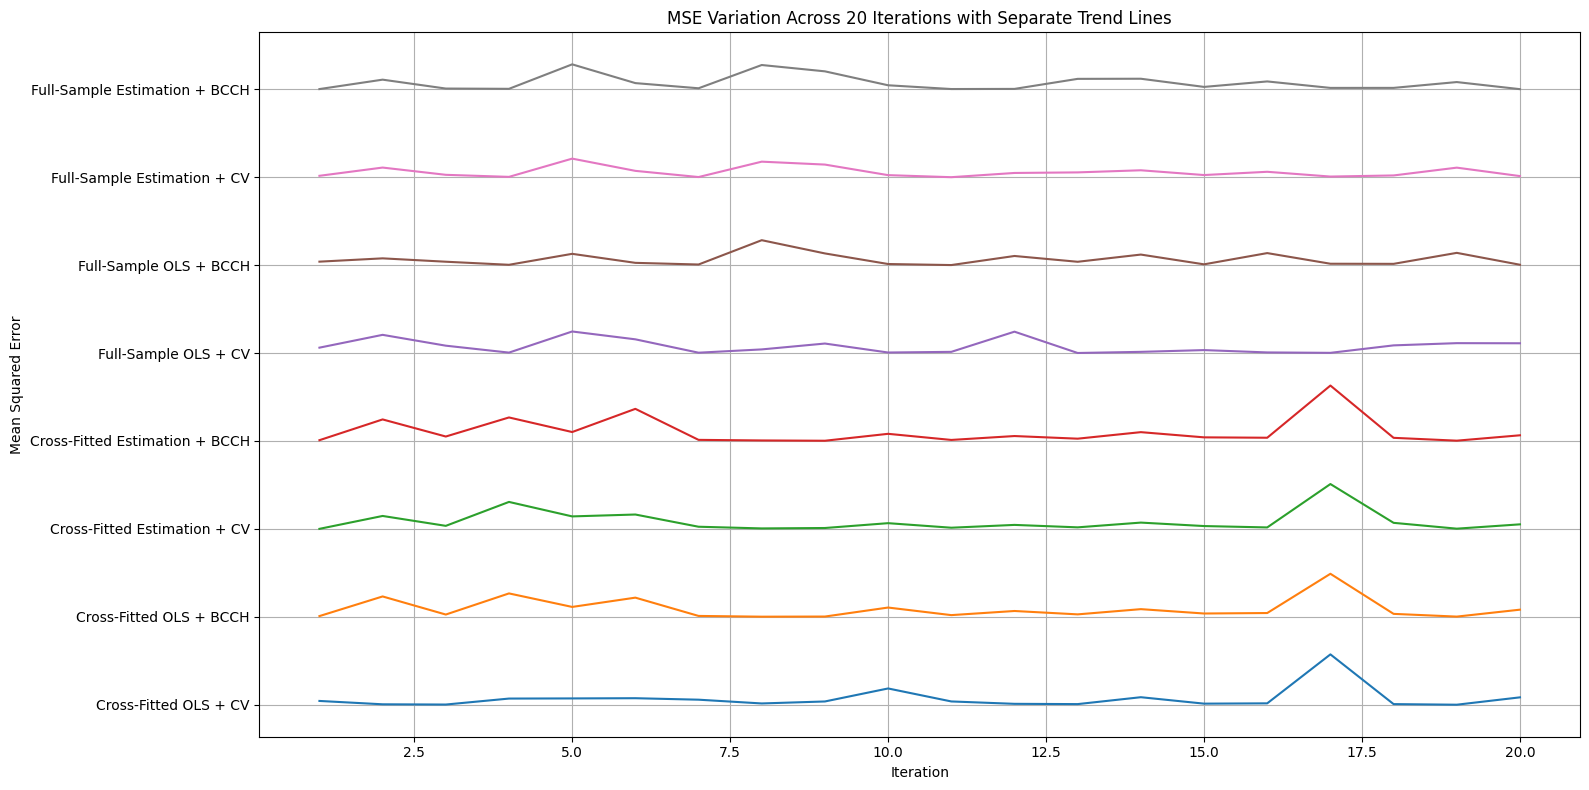

In [12]:
# Plotting the trend lines vertically separated with model names on both sides
plt.figure(figsize=(16, 8))
model_names = list(results.keys())
n_models = len(model_names)
spacing = 0.1

for i, (method, values) in enumerate(results.items()):
    mse_per_iteration = (np.array(values) - 1)**2
    plt.plot(range(1, n_repetitions + 1), mse_per_iteration + i * spacing, label=method)

plt.xlabel('Iteration')
plt.ylabel('Mean Squared Error')
plt.yticks(np.arange(0, n_models * spacing, spacing), model_names, rotation=0)
plt.title('MSE Variation Across 20 Iterations with Separate Trend Lines')
plt.grid(True)
plt.tight_layout()

plt.show()

The graph shows the Mean Squared Error (MSE) variations over 20 iterations for different models. The ***Full-Sample Estimation + CV method*** consistently has the lowest and most stable MSE values, indicating it performs the best. In contrast, cross-fitted methods show higher volatility in MSE, with noticeable sudden bumps and spikes, particularly in the Cross-Fitted Estimation + BCCH and Cross-Fitted Estimation + CV models. This suggests that cross-fitted methods are less consistent. Additionally, models using cross-validation (CV) for parameter selection generally have lower MSEs compared to those using the BCCH method, showing that CV is more effective for tuning parameters.

### Question 5: 2SLS Model

#### a) Consider the demand equation:

$$
Q_i = \alpha + \beta P_i + \gamma' W_i + \epsilon_i,
$$

Where, 
- $Q_i$ is quantity on day $i$
- $P_i$ is price on day $i$
- $W_i$ is a vector including rainy, cold, day1, day2, day3, and day4 variables on day $i$
- $\epsilon_i$ is noise

#### Assume that the variables in $W_i$ are exogenous but $P_i$ is endogenous. Estimate the demand equation using 2SLS with stormy and mixed variables being instruments for the price. Report an estimate of $\beta$ as well as a 95% confidence interval for it.

In [13]:
# Load your dataset
data = pd.read_csv('Final_exam_data.csv')

# Define the dependent and exogenous variables
Y = data['qty']  # Quantity sold (log)
X = data['price']  # Endogenous regressor (log price)
W = data[['rainy', 'cold', 'day1', 'day2', 'day3', 'day4']]  # Exogenous variables
Z = data[['stormy', 'mixed']]  # Instruments

# Add a constant to the exogenous variables for both stages
W_with_const = sm.add_constant(W)

# First stage regression: Regress price on instruments and exogenous variables
first_stage = sm.OLS(X, pd.concat([W_with_const, Z], axis=1)).fit()
data['price_hat'] = first_stage.fittedvalues

# Second stage regression: Regress quantity on the fitted values of price and exogenous variables
second_stage = sm.OLS(Y, pd.concat([data['price_hat'], W_with_const], axis=1)).fit()

# Print the summary of the second stage regression
print(second_stage.summary())

# Extract the estimate of β and its 95% confidence interval
beta = second_stage.params['price_hat']
beta_conf_int = second_stage.conf_int().loc['price_hat']

print("")
    
# Display the results in blue and bold text
print("\033[94mEstimate of β:\033[0m", f"\033[1m{beta:.4f}\033[0m")
print("\033[94m95% Confidence Interval for β:\033[0m", f"\033[1m({beta_conf_int[0]:.4f}, {beta_conf_int[1]:.4f})\033[0m")


                            OLS Regression Results                            
Dep. Variable:                    qty   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     14.98
Date:                Tue, 11 Jun 2024   Prob (F-statistic):           4.92e-19
Time:                        13:12:41   Log-Likelihood:                -1599.8
No. Observations:                1554   AIC:                             3216.
Df Residuals:                    1546   BIC:                             3258.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
price_hat     -0.9154      0.114     -8.023      0.0

Demand elasticity measures the responsiveness of quantity demanded to changes in price. In this problem, we are dealing with the price elasticity of demand, which indicates how much the quantity of Whiting fish sold responds to a change in its price. Since we are using a ***log-log model***, the coefficient of the price variable directly represents the elasticity.

The negative coefficient of price ($\beta$) suggests that an ***increase in price*** leads to a ***decrease in the quantity*** demanded. Specifically, a 1% increase in price results in approximately a ***0.9154%*** decrease in the quantity demanded of Whiting fish.

Since the elasticity of -0.9154 is less than -1 in absolute value, the demand is **Inelastic**.

However, looking at the 95% interval, we can conclude that the the true elasticity lies in the range of from -1.1392 to -0.6916.